In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob

import time
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
from IPython.display import Image
from skimage import io

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.layers.experimental import preprocessing
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
import cv2
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display
from keras_preprocessing.image import ImageDataGenerator

In [ ]:
img_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/brain_tumor_segmentation/lgg-mri-segmentation/kaggle_3m/data.csv')
img_data.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [ ]:
img_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [ ]:
img_data.shape

(110, 18)

In [ ]:
from datetime import datetime

now = datetime.now()
data_path = []
for sub_dir_path in glob.glob("/content/drive/MyDrive/Colab Notebooks/brain_tumor_segmentation/lgg-mri-segmentation/kaggle_3m/"+"*"):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            mask_path = sub_dir_path + '/' + filename
            data_path.extend([dir_name, mask_path])
    except Exception as e:
        print(e)
then = datetime.now()
print(then-now)

[Errno 20] Not a directory: '/content/drive/MyDrive/Colab Notebooks/brain_tumor_segmentation/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/content/drive/MyDrive/Colab Notebooks/brain_tumor_segmentation/lgg-mri-segmentation/kaggle_3m/data.csv'
0:00:00.137305


In [ ]:
# seperating image and mask
filenames = data_path[::2]
masks = data_path[1::2]
len(masks)

7856

In [ ]:
df = pd.DataFrame(data={'patient_id':filenames,'img_path':masks})
df

,patient_id,img_path
0,TCGA_CS_4941_19960909,/content/drive/MyDrive/Colab Notebooks/brain_t...
1,TCGA_CS_4941_19960909,/content/drive/MyDrive/Colab Notebooks/brain_t...
2,TCGA_CS_4941_19960909,/content/drive/MyDrive/Colab Notebooks/brain_t...
3,TCGA_CS_4941_19960909,/content/drive/MyDrive/Colab Notebooks/brain_t...
4,TCGA_CS_4941_19960909,/content/drive/MyDrive/Colab Notebooks/brain_t...
...,...,...
7851,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/brain_t...
7852,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/brain_t...
7853,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/brain_t...
7854,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/brain_t...


In [ ]:
original_img = df[~df['img_path'].str.contains("mask")]
mask_img = df[df['img_path'].str.contains("mask")]

In [ ]:
original_img,mask_img

(                 patient_id                                           img_path
 1     TCGA_CS_4941_19960909  /content/drive/MyDrive/Colab Notebooks/brain_t...
 2     TCGA_CS_4941_19960909  /content/drive/MyDrive/Colab Notebooks/brain_t...
 5     TCGA_CS_4941_19960909  /content/drive/MyDrive/Colab Notebooks/brain_t...
 6     TCGA_CS_4941_19960909  /content/drive/MyDrive/Colab Notebooks/brain_t...
 8     TCGA_CS_4941_19960909  /content/drive/MyDrive/Colab Notebooks/brain_t...
 ...                     ...                                                ...
 7842  TCGA_HT_A61B_19991127  /content/drive/MyDrive/Colab Notebooks/brain_t...
 7843  TCGA_HT_A61B_19991127  /content/drive/MyDrive/Colab Notebooks/brain_t...
 7846  TCGA_HT_A61B_19991127  /content/drive/MyDrive/Colab Notebooks/brain_t...
 7847  TCGA_HT_A61B_19991127  /content/drive/MyDrive/Colab Notebooks/brain_t...
 7851  TCGA_HT_A61B_19991127  /content/drive/MyDrive/Colab Notebooks/brain_t...
 
 [3928 rows x 2 columns],
            

In [ ]:
imgs = sorted(original_img["img_path"].values, key=lambda x : int(x[130:-4]))
masks = sorted(mask_img["img_path"].values, key=lambda x : int(x[130:-9]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Image path:", imgs[idx], "\nMask path:", masks[idx])

Image path: /content/drive/MyDrive/Colab Notebooks/brain_tumor_segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_17.tif 
Mask path: /content/drive/MyDrive/Colab Notebooks/brain_tumor_segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_17_mask.tif


In [ ]:
mri_df = pd.DataFrame({"patient_id": original_img.patient_id.values,"img_path": imgs,
                           'mask_path':masks})
mri_df

,patient_id,img_path,mask_path
0,TCGA_CS_4941_19960909,/content/drive/MyDrive/Colab Notebooks/brain_t...,/content/drive/MyDrive/Colab Notebooks/brain_t...
1,TCGA_CS_4941_19960909,/content/drive/MyDrive/Colab Notebooks/brain_t...,/content/drive/MyDrive/Colab Notebooks/brain_t...
2,TCGA_CS_4941_19960909,/content/drive/MyDrive/Colab Notebooks/brain_t...,/content/drive/MyDrive/Colab Notebooks/brain_t...
3,TCGA_CS_4941_19960909,/content/drive/MyDrive/Colab Notebooks/brain_t...,/content/drive/MyDrive/Colab Notebooks/brain_t...
4,TCGA_CS_4941_19960909,/content/drive/MyDrive/Colab Notebooks/brain_t...,/content/drive/MyDrive/Colab Notebooks/brain_t...
...,...,...,...
3923,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/brain_t...,/content/drive/MyDrive/Colab Notebooks/brain_t...
3924,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/brain_t...,/content/drive/MyDrive/Colab Notebooks/brain_t...
3925,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/brain_t...,/content/drive/MyDrive/Colab Notebooks/brain_t...
3926,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/brain_t...,/content/drive/MyDrive/Colab Notebooks/brain_t...


In [ ]:
def get_diagnosis(img_path):
    value = np.max(cv2.imread(img_path))
    if value > 0 : 
        return 1
    else:
        return 0

In [ ]:
mri_df.head()

,patient_id,img_path,mask_path
0,TCGA_CS_4941_19960909,/content/drive/MyDrive/Colab Notebooks/brain_t...,/content/drive/MyDrive/Colab Notebooks/brain_t...
1,TCGA_CS_4941_19960909,/content/drive/MyDrive/Colab Notebooks/brain_t...,/content/drive/MyDrive/Colab Notebooks/brain_t...
2,TCGA_CS_4941_19960909,/content/drive/MyDrive/Colab Notebooks/brain_t...,/content/drive/MyDrive/Colab Notebooks/brain_t...
3,TCGA_CS_4941_19960909,/content/drive/MyDrive/Colab Notebooks/brain_t...,/content/drive/MyDrive/Colab Notebooks/brain_t...
4,TCGA_CS_4941_19960909,/content/drive/MyDrive/Colab Notebooks/brain_t...,/content/drive/MyDrive/Colab Notebooks/brain_t...


In [ ]:
now = datetime.now()
mri_df['mask'] = mri_df['mask_path'].apply(lambda x: get_diagnosis(x))

mri_df['mask_path'] = mri_df['mask_path'].apply(lambda x: str(x))
mri_df
print(datetime.now()-now)

In [ ]:
mri_df.drop(columns=['patient_id'],inplace=True)

In [ ]:
mri_train, mri_test = train_test_split(mri_df,test_size = 0.1)
mri_train, mri_val = train_test_split(mri_train,test_size = 0.2)

print('Training data shape is {0}'.format(mri_train.values.shape))
print('Test data shape is {0}'.format(mri_test.values.shape))
mri_train.sample(n=5)

Training data shape is (2828, 3)
Test data shape is (393, 3)


,img_path,mask_path,mask
2497,/content/drive/MyDrive/Colab Notebooks/brain_t...,/content/drive/MyDrive/Colab Notebooks/brain_t...,1
2614,/content/drive/MyDrive/Colab Notebooks/brain_t...,/content/drive/MyDrive/Colab Notebooks/brain_t...,0
931,/content/drive/MyDrive/Colab Notebooks/brain_t...,/content/drive/MyDrive/Colab Notebooks/brain_t...,0
2543,/content/drive/MyDrive/Colab Notebooks/brain_t...,/content/drive/MyDrive/Colab Notebooks/brain_t...,1
2113,/content/drive/MyDrive/Colab Notebooks/brain_t...,/content/drive/MyDrive/Colab Notebooks/brain_t...,1


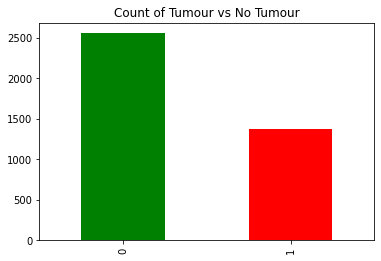

In [ ]:
mri_df['mask'].value_counts().plot(kind='bar',color=['g','r'],
                title='Count of Tumour vs No Tumour')

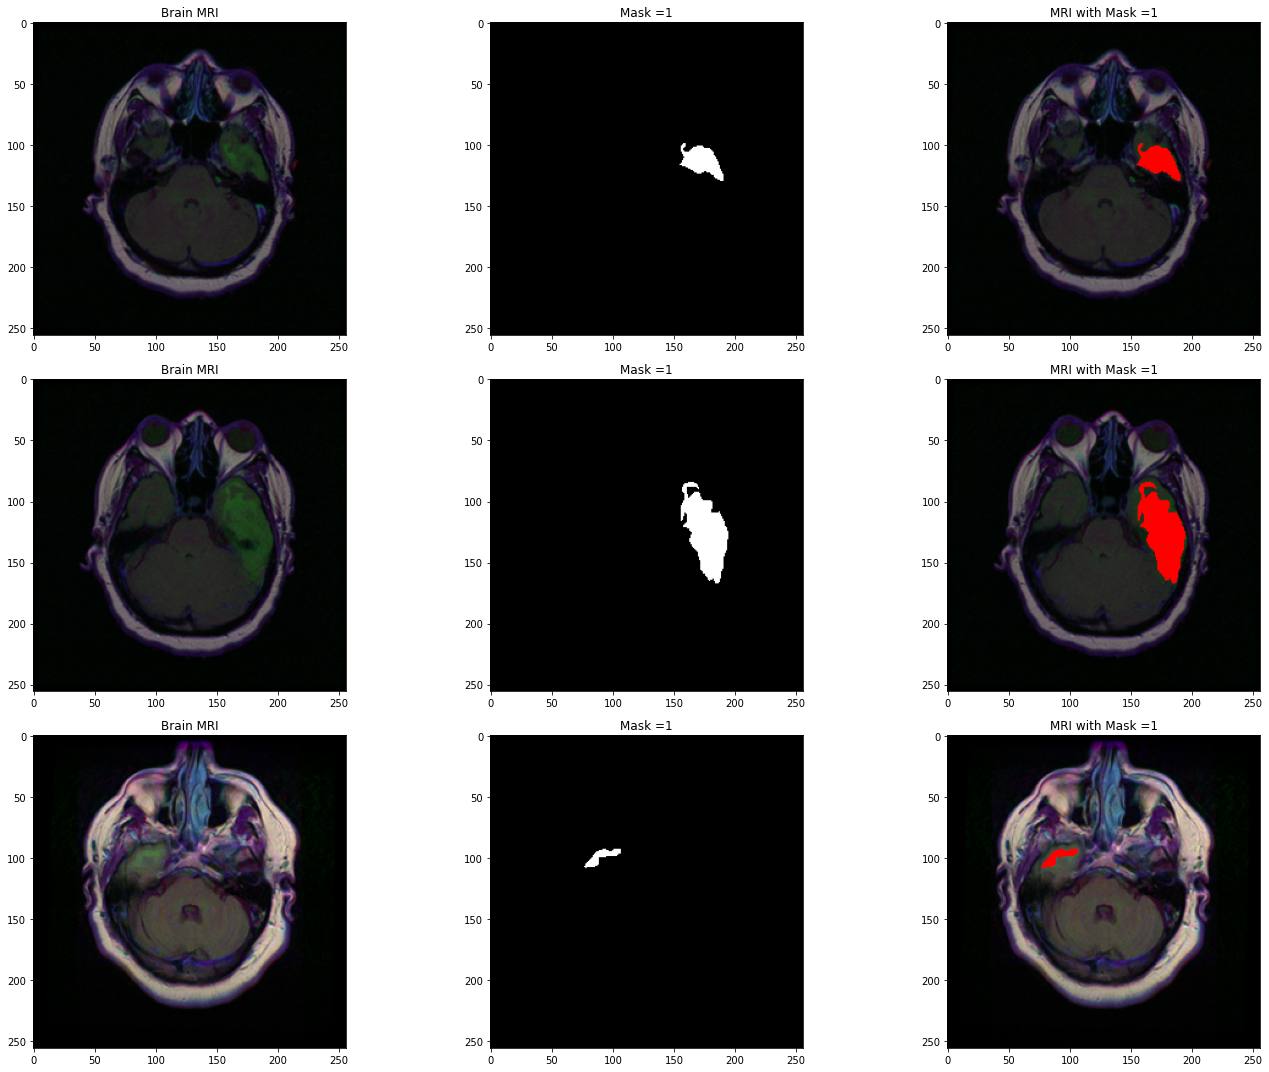

In [ ]:
count = 0
i = 0
fig,axs = plt.subplots(3,3, figsize=(20,15))
for mask in mri_df['mask']:
    if (mask==1):
        img = io.imread(mri_df.img_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(mri_df.mask_path[i])
        axs[count][1].title.set_text("Mask =" + str(mri_df['mask'][i]))
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (255,0,0)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask =" + str(mri_df['mask'][i]))
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==3):
        break
        
fig.tight_layout()

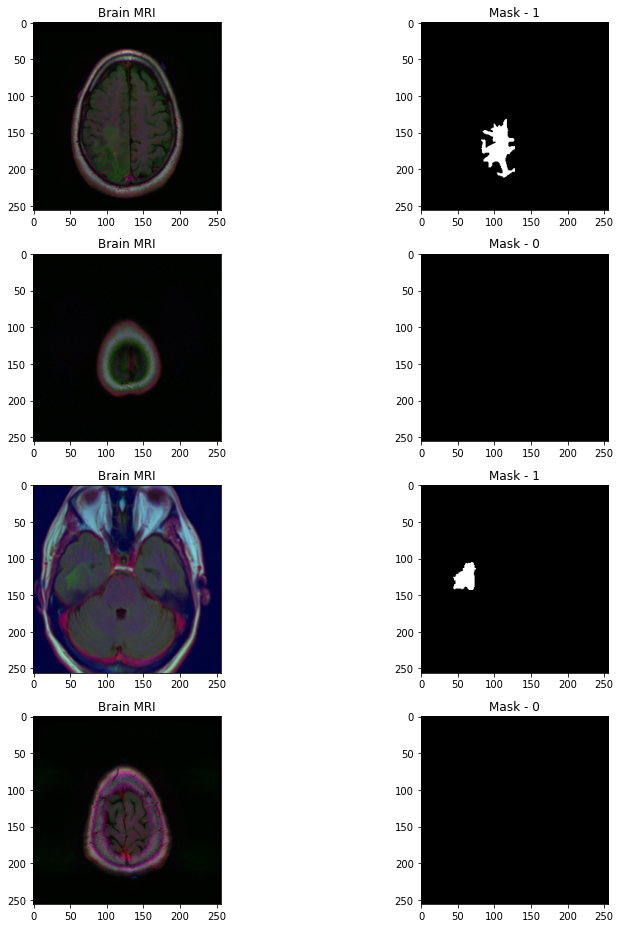

In [ ]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately 

fig, axs = plt.subplots(4,2, figsize=(13,13))
count = 0
for x in range(4):
  i = random.randint(0, len(mri_df)) 
  axs[count][0].title.set_text("Brain MRI") 
  axs[count][0].imshow(cv2.imread(mri_df.img_path[i])) 
  axs[count][1].title.set_text("Mask - " + str(mri_df['mask'][i])) 
  axs[count][1].imshow(cv2.imread(mri_df.mask_path[i])) 
  count += 1

fig.tight_layout()

In [ ]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "img_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

In [ ]:
def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [ ]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(mri_train, 32,
                                train_generator_args,
                                target_size=(256, 256))
    
val_gen = train_generator(mri_val, 32,
                                dict(),
                                target_size=(256, 256))

In [ ]:
def unet(pretrained_weights = None,input_size = (256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    bn_1 = BatchNormalization(axis=3)(conv1)
    act_1 = Activation('relu')(bn_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(act_1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    bn_2 = BatchNormalization(axis=3)(conv2)
    act_2 = Activation('relu')(bn_2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(act_2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    bn_3 = BatchNormalization(axis=3)(conv3)
    act_3 = Activation('relu')(bn_3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(act_3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    bn_4 = BatchNormalization(axis=3)(conv4)
    act_4 = Activation('relu')(bn_4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(act_4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    bn_5 = BatchNormalization(axis=3)(conv5)
    act_5 = Activation('relu')(bn_5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    bn_6 = BatchNormalization(axis=3)(conv6)
    act_6 = Activation('relu')(bn_6)
    
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv7)
    bn_7 = BatchNormalization(axis=3)(conv7)
    act_7 = Activation('relu')(bn_7)

    
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv8)
    bn_8 = BatchNormalization(axis=3)(conv8)
    act_8 = Activation('relu')(bn_8)
    
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    bn_9 = BatchNormalization(axis=3)(conv9)
    act_9 = Activation('relu')(bn_9)
    
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(act_9)

    model = model = Model(inputs=[inputs] , outputs = [conv10])    
    return model

In [ ]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

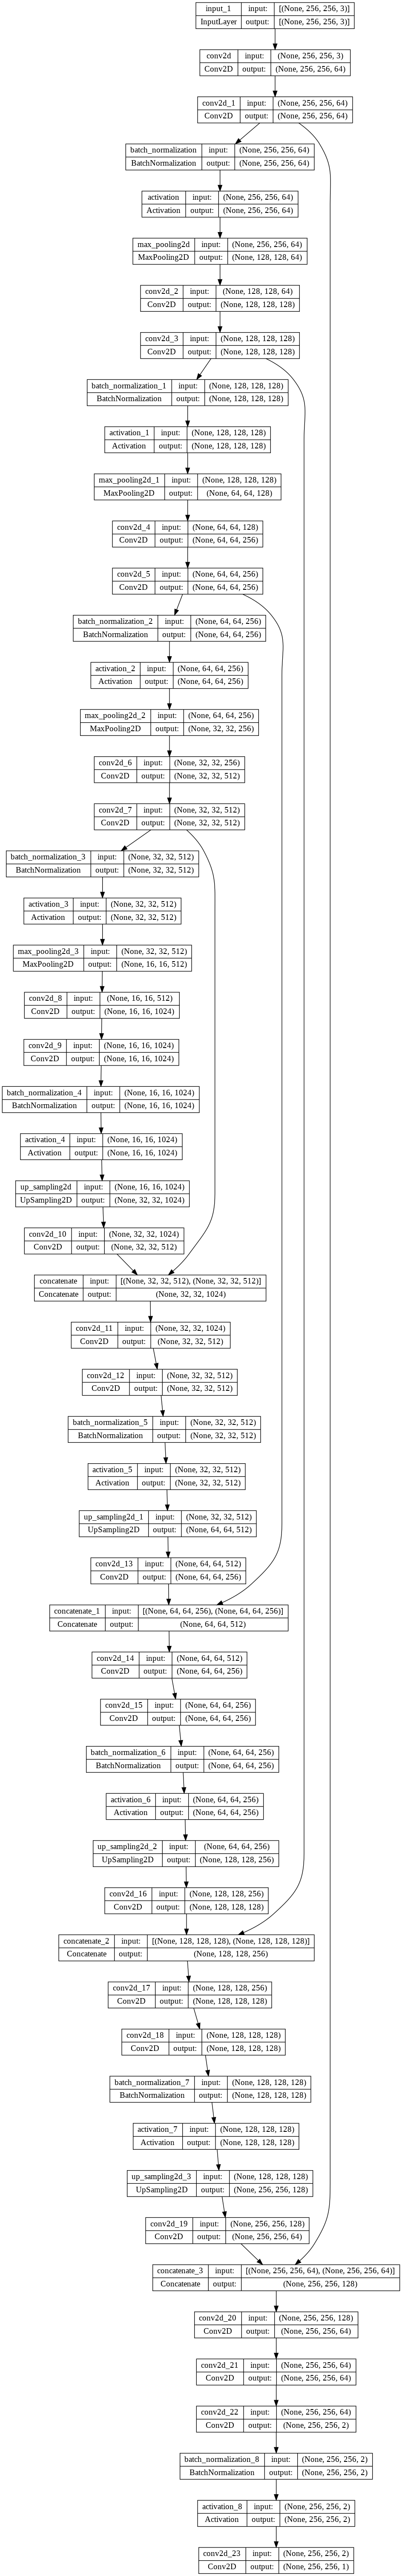

In [ ]:
plot_model(model, to_file='unet_model.png', show_shapes=True)
Image("unet_model.png")

In [ ]:
lr_reduction = ReduceLROnPlateau(monitor='val_iou',patience=8, verbose=1,
                                 factor=0.4, min_lr=0.0001)

early_stop = EarlyStopping(monitor='val_iou', min_delta=0.00001, patience=6, 
                           mode='auto', restore_best_weights=True)

model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', verbose=1,monitor='val_iou',
                                   save_best_only=True)

In [ ]:
smooth =100
def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [ ]:
def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
EPOCH = 100
learning_rate = 1e-3

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-3/32, amsgrad=False), 
              metrics=["binary_accuracy"])

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-3/32, amsgrad=False), 
              loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

In [ ]:
history = model.fit(train_gen,steps_per_epoch=len(mri_train)/32,
                    epochs=EPOCH ,validation_data=val_gen,validation_steps=len(mri_val) / 32,
                    callbacks=[model_checkpoint])

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/10
89/88 [==============================] - ETA: -5s - loss: 0.9724 - binary_accuracy: 0.9896 - iou: 0.0140 - dice_coef: 0.0275Found 707 validated image filenames.
Found 707 validated image filenames.

Epoch 1: val_iou improved from inf to 0.01372, saving model to unet_membrane.hdf5
88/88 [==============================] - 1036s 12s/step - loss: 0.9724 - binary_accuracy: 0.9896 - iou: 0.0140 - dice_coef: 0.0275 - val_loss: 0.9745 - val_binary_accuracy: 0.9897 - val_iou: 0.0137 - val_dice_coef: 0.0268
Epoch 2/10
89/88 [==============================] - ETA: 0s - loss: 0.9684 - binary_accuracy: 0.9896 - iou: 0.0161 - dice_coef: 0.0315
Epoch 2: val_iou did not improve from 0.01372
88/88 [==============================] - 59s 670ms/step - loss: 0.9684 - binary_accuracy: 0.9896 - iou: 0.0161 - dice_coef: 0.0315 - val_loss: 0.9620 - val_binary_accuracy: 0.9898 - val_iou: 0.0193 - val_dice_coef: 0.0375
Epoch 3

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.37.125.138:8470
Number of replicas: 8
